In [1]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd
from pandas import DataFrame as df

In [2]:
# plot example cough
train_path = 'Freesound_Audio_Train/'
file = '00d1fe46.wav'
sample_rate, samples = wavfile.read(str(train_path) + file)
tr_labels = pd.read_csv('train_binary_labels.csv')
ts_labels = pd.read_csv('test_binary_labels.csv')

In [3]:
samples.shape

(197568,)

In [4]:
"""Log of spectrogram is much cleaner for plotting and is connected to how humans hear.
see https://www.kaggle.com/davids1992/speech-representation-and-data-exploration"""
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

In [6]:
print(sample_rate)
print('\n ' + str(len(samples)))
print(sample_rate/len(samples))

44100

 197568
0.22321428571428573


In [7]:
np.linspace(0,sample_rate/len(samples), len(samples)).size

197568

Text(0.5, 0, 'Seconds')

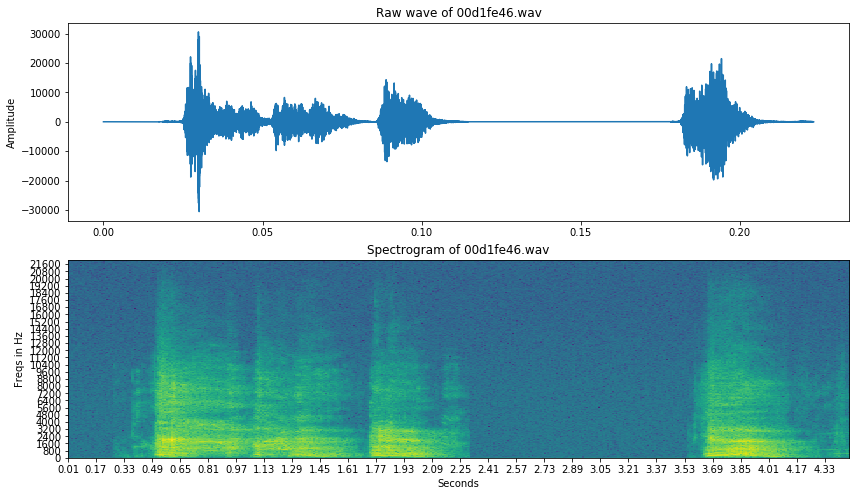

In [8]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0,sample_rate/len(samples), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + file)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# Dataset & Visualizing Classes

In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import *
from skimage import io, transform
from PIL import Image
# from torchaudio.transforms import MFCC
import librosa
import os

ModuleNotFoundError: No module named 'torchaudio'

In [ ]:
# turn our freesound dataset into cough, 1, and non-cough, 0 labels
train_labels = pd.read_csv('train_labels.csv')
test_labels = pd.read_csv('test_labels.csv')

In [ ]:
train_non_cough_idx = train_labels[train_labels.iloc[:,1] != 'Cough'].index
train_cough_idx = train_labels[train_labels.iloc[:,1] == 'Cough'].index
test_non_cough_idx = test_labels[test_labels.iloc[:,1] != 'Cough'].index
test_cough_idx = test_labels[test_labels.iloc[:,1] == 'Cough'].index

In [ ]:
new_train = train_labels.copy()
new_test = test_labels.copy()

In [ ]:
new_train.iloc[train_non_cough_idx,1] = 0
new_train.iloc[train_cough_idx,1] = 1
new_test.iloc[test_non_cough_idx,1] = 0
new_test.iloc[test_cough_idx,1] = 1

In [ ]:
new_train.to_csv('train_binary_labels.csv', index=False)
new_test.to_csv('test_binary_labels.csv', index=False)

In [ ]:
class FreesoundDataset(Dataset):
    def __init__(self, csv_labels, root_dir, transform=None, test=False):
        """
        Args:
            csv_labels: path to labels file
            root_dir: path to file directory
            transform: optional transforms
            test: training vs testing mode
        """
        self.labels = pd.read_csv(csv_labels)
        self.transform = transform
        self.test = test
        
        # root path depends on training vs testing data files
        if self.test:
            self.root = os.path.join(root_dir,'Freesound_Audio_Test')
        else:
            self.root = os.path.join(root_dir,'Freesound_Audio_Train')

        
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        filename = self.labels.iloc[idx,0]
        wave_path = os.path.join(self.root,filename)
        sample_rate, sample = wavfile.read(wave_path)
        if self.transform:
            sample = self.transform(sample)
            
        if self.test:
            return sample
        else:
            label = self.labels.iloc[idx,1]
            return sample, label

In [ ]:
freesound = FreesoundDataset(csv_labels='train_labels.csv',root_dir='.')

In [ ]:
freesound[10]

In [ ]:
"""Mel-frequency cepstral coefficients form gives us
    approximation of human auditory response.
    This also attempts to remove speaker dependent qualities.
    our sample rate is 44100 after reading the wav files,
    start with 20 mfccs then increase if needed"""
trns = transforms.Compose([
    lambda x: x.astype(np.float32) / np.max(x),
    lambda x: librosa.feature.mfcc(x, sr=44100, n_mfcc=40),
    transforms.ToTensor()
])

In [ ]:
FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=trns)[23][0].shape

In [ ]:
dataloader = DataLoader(FreesoundDataset(csv_labels='train_binary_labels.csv',root_dir='.',transform=trns), batch_size=10, shuffle=True, num_workers=0)

In [ ]:
for idx, (sample, label) in enumerate(dataloader):
    print(sample.numpy().shape)
    #plt.imshow(sample.numpy()[0,:,:])
    if idx == 2:
        break